<a href="https://colab.research.google.com/github/nmamie/ML4H_Project1/blob/master/ML4H_Project1_Task1_Nici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Heart Disease Prediction**

## Preparation

In [89]:
## basic packages
import pandas as pd
import numpy as np
import math
from IPython.display import display

In [90]:
## setup
import warnings
warnings.filterwarnings("ignore")

path = "/content/drive/MyDrive/1) ETH/3) ML in Healthcare/5) Assignments/Project 1/Data Heart Failure/"

In [91]:
## data import
train_data = pd.read_csv(path + "train_val_split.csv")
test_data = pd.read_csv(path + "test_split.csv")

## **Q1: Exploratory Data Analysis**

### Basic checks

In [ ]:
## examine head
train_data.head()

In [ ]:
## check dataset sample size & dimensionality
n = len(train_data)
p = len(train_data.columns) - 1
print("No. of samples:  ", n)
print("No. of features: ", p)

In [ ]:
## check for missing data
train_data.isnull().sum()

**Conclusions:**
*   We have significantly more observations than variables. Hence, no further problems arise.
*   There are no missing values.

**Implications:**
*   None

### Data types and distributions of variables

In [ ]:
## explore feature data types
train_data.dtypes

*FastingBS* and *HeartDisease* are binary, hence change to data type "object" for plotting.

In [92]:
## change data type of categorical variables to "object"
train_data["FastingBS"] = train_data["FastingBS"].astype("object")
train_data["HeartDisease"] = train_data["HeartDisease"].astype("object")

In [93]:
# save variable & names
fts = train_data.drop("HeartDisease", axis=1).columns.tolist()
num_fts = train_data.drop("HeartDisease", axis=1).select_dtypes(exclude="object").columns.tolist()
cat_fts = train_data.drop("HeartDisease", axis=1).select_dtypes(include="object").columns.tolist()
num_vars = train_data.select_dtypes(include="int64").columns.tolist()
cat_vars = train_data.select_dtypes(include="object").columns.tolist()

In [10]:
# summary statistics
display(train_data[num_fts].round(2))
display(train_data[cat_fts])

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,40,140,289,172,0.0
1,37,130,283,98,0.0
2,48,138,214,108,1.5
3,54,150,195,122,0.0
4,39,120,339,170,0.0
...,...,...,...,...,...
729,41,120,157,182,0.0
730,57,140,241,123,0.2
731,45,110,264,132,1.2
732,68,144,193,141,3.4


,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,0,Normal,N,Up
1,M,ATA,0,ST,N,Up
2,F,ASY,0,Normal,Y,Flat
3,M,NAP,0,Normal,N,Up
4,M,NAP,0,Normal,N,Up
...,...,...,...,...,...,...
729,M,ATA,0,Normal,N,Up
730,F,ASY,0,Normal,Y,Flat
731,M,TA,0,Normal,N,Flat
732,M,ASY,1,Normal,N,Flat


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# categorical features
fig, axs = plt.subplots(2, math.ceil(len(cat_fts)/2), figsize=(15, 10))
fig.suptitle('Categorical Features', fontsize=16)
for i, col in enumerate(cat_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.countplot(x=col, data=train_data, ax=ax)

# numerical features
fig, axs = plt.subplots(2, math.ceil(len(num_fts)/2), figsize=(15, 10))
fig.suptitle('Numerical Features', fontsize=16)
for i, col in enumerate(num_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.histplot(x=col, data=train_data, ax=ax)

In [ ]:
print("0s in RestingBP:")
print(" - Train Data: ", (train_data["RestingBP"] == 0).sum())
print(" - Test Data:  ", (test_data["RestingBP"] == 0).sum())

print("")
print("0s in RestingBP:")
print(" - Train Data: ", (train_data["Cholesterol"] == 0).sum())
print(" - Test Data:  ", (test_data["Cholesterol"] == 0).sum())

**Conclusions:**

1.   Some features are categorical, i.e. lack interpretability of differences in or ordering of their values.
2.   The dataset is imbalanced w.r.t. a couple of features, incl. *sex*, *chest pain type*, and *fasting blood sugar*. Importantly, however, the dataset is balanced w.r.t. the outcome variable, *heart disease*.
3.   *Cholesterol:* Many values of are exactly 0. Since virtually all values above 0 are >100, this seems highly unrealistic. Instead, we interpret this as missing values.
4.   *RestingBP:* There exist an observation with resting blood pressure of 0, which seems equally unrealistic. 

**Implications:**

1.   Create dummy variables or use one-hot encoding for the respective features.
2.  ...
3.   Since there are many observations with this anomaly, create a dummy variable indicating whether a patient's cholesterol measurement is missing or not.
4.   Since there is only 1 observation with this anomaly, ...

## Preprocessing

For the purpose of the EDA, our preprocessing pipeline consists of the following steps:

1.   Create dummy variable for *Cholesterol = 0*
2.   Mark *Cholesterol* as *NA* whenever it is 0
2.   Create dummy variables for categories

In [94]:
## add dummy for cholesterol=0
train_data["Cholesterol"].replace(0, np.nan, inplace=True)
test_data["Cholesterol"].replace(0, np.nan, inplace=True)

train_data.insert(loc=5, column="Chol_NA", value=train_data["Cholesterol"].isna()*1)
test_data.insert(loc=5, column="Chol_NA", value=test_data["Cholesterol"].isna()*1)

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# pipeline for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop=None))])

# preprocessor
preprocessing = ColumnTransformer(transformers = [("pass", "passthrough", ["HeartDisease", "Chol_NA"] + num_fts),
                                                  ("drop", "drop", fts),
                                                  ("cat", cat_transformer, cat_fts)],
                                      remainder = "passthrough")

In [96]:
## apply preprocessing pipeline to data
train_proc_1 = preprocessing.fit_transform(train_data)
test_proc_1 = preprocessing.fit_transform(test_data)

var_names = preprocessing.get_feature_names_out().tolist()
var_names = [var_names[i].replace("pass__", "").replace("num__", "").replace("cat__", "") for i in range(len(var_names))]
ft_names = var_names.copy()
ft_names.remove("HeartDisease")

train_proc_1 = pd.DataFrame(train_proc_1, columns=var_names)
test_proc_1 = pd.DataFrame(test_proc_1, columns=var_names)

ft_names = train_proc_1.columns

In [97]:
## set numerical features to float, categorical to int
train_proc_1[num_fts] = train_proc_1[num_fts].astype("float64")
test_proc_1[num_fts] = test_proc_1[num_fts].astype("float64")

train_proc_1.loc[:, ~train_proc_1.columns.isin(num_fts)] = train_proc_1.loc[:, ~train_proc_1.columns.isin(num_fts)].astype("int64")
test_proc_1.loc[:, ~test_proc_1.columns.isin(num_fts)] = test_proc_1.loc[:, ~test_proc_1.columns.isin(num_fts)].astype("int64")

## Dependencies

Following intermediate data processing for exploratory data analysis only:

In [ ]:
## 

# HeartDisease & categorical features
fig, axs = plt.subplots(2, math.ceil(len(cat_fts)/2), figsize=(15, 10))
fig.suptitle('Categorical Features', fontsize=16)
for i, col in enumerate(cat_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.countplot(x=train_data[col], data=train_proc_1, ax=ax, hue="HeartDisease")

# HeartDisease & continuous features
figure = plt.figure(figsize=(20,10))
figure.suptitle('Continuous Features', fontsize=16)
sns.pairplot(train_data[num_fts + ["HeartDisease"]], hue='HeartDisease', palette='Blues')

In [98]:
## define default variables and drop their dummy

default_vars = ["Sex_M",
                "ChestPainType_ASY",
                "FastingBS_0",
                "RestingECG_Normal",
                "ExerciseAngina_N",
                "ST_Slope_Flat"]

train_eda = train_proc_1.drop(default_vars, axis=1, inplace=False)

To examine dependencies, we remove the collinearity and drop one category of each categorical variable. Note the definition of the "default" values of categorical features:
*   *HeartDisease:* 0
*   *Sex*: M
*   *ChestPainType:* ASY
*   *FastingBS:* 0
*   *RestingECG:* Normal
*   *ExerciseAngina:* N
*   *ST_Slope:* Flat

We compute rank correlations between non-categorical variables, since these can capture also non-linear (monotonic) dependence structures. In case of binary variables (which includes the outcome variable *HeartDisease*), it corresponds to linear correlation.

In [ ]:
## compute rank correlations
rk_corr = train_eda.corr(method="spearman")
print("Rank correlation:")
plt.figure(figsize=(10, 10))
sns.heatmap(rk_corr, cmap="YlGnBu")

In [ ]:
## significant rank correlations (|r|>0.4)
sig_corr = rk_corr[abs(rk_corr)>0.4]
sig_corr.replace(np.nan, "-", inplace=True)
sig_corr

**Conclusions**:
*   The plots and rank correlations suggest *HeartDisease* has a  strong positive association with *ExerciseAngina = "Y"*, *Oldpeak*, and *ChestPainType = "ASY".
*    Strong negative associations can be seen with *MaxHR*, *ChestPainType = "ATA"*, and *ST_Slope = "Up"*.
*   Some features are also highly correlated. For example, *ExerciseAngina* & *Oldpeak* are significantly positively associated, while *ExerciseAngina* & *MaxHR*, *Oldpeak* & *ST_Slope = "Up"*, and *ExerciseAngina = "Y"* & *ST_Slope = "Up"* are significantly negatively correlated.
*   Hence, among the observed variables, ...

**Conclusions**:
*    When interpreting feature selection outputs, one needs to be cautious due to correlated predictors.

## **Q2: Logistic Lasso Regression**

For the purposes of modelling, the further preprocessing pipeline consists of the following steps:

*   For categorical features:
  1.  Get back dummy variables for *each* category (justification later)

*  For continuous features
  1.   Impute missing values (incl. unrealistic 0 values) with the mean
  2.   Standardize to mean 0 and standard deviation 1
  3.   Create dummy variable for *Cholesterol = 0*

Standardization usually improves accuracy and variable selection.

In [129]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# copy df
train_proc_2 = train_proc_1.copy()
test_proc_2 = test_proc_1.copy()

# determine scaling & imputation strategy
scaler = StandardScaler(with_mean=False)
imputer = SimpleImputer(strategy="mean")

# standardize features (according to training set)
scaler.fit(train_proc_1.drop("HeartDisease", axis=1))
train_proc_2 = scaler.transform(train_proc_1.drop("HeartDisease", axis=1))
test_proc_2 = scaler.transform(test_proc_1.drop("HeartDisease", axis=1))

# impute missing values
train_proc_2 = imputer.fit_transform(train_proc_2)
test_proc_2 = imputer.fit_transform(test_proc_2)

# put back to pandas
train_proc_2 = pd.DataFrame(train_proc_2, columns=ft_names)
test_proc_2 = pd.DataFrame(test_proc_2, columns=ft_names)

# add back label column
train_proc_2 = pd.concat([train_data["HeartDisease"], train_proc_2], axis=1)
test_proc_2 = pd.concat([test_data["HeartDisease"], test_proc_2], axis=1)

# make HeartDisease integer
train_proc_2["HeartDisease"] = train_proc_2["HeartDisease"].astype("int64")
test_proc_2["HeartDisease"] = test_proc_2["HeartDisease"].astype("int64")

In [130]:
X_train = train_proc_2.drop("HeartDisease", axis=1)
X_test = test_proc_2.drop("HeartDisease", axis=1)

y_train = train_proc_2["HeartDisease"]
y_test = test_proc_2["HeartDisease"]

When using regularization, we need to account for the fact that we introduced dummy variables. Specifically, we want to regularize the inclusion of entire variables, e.g. "Sex", and not certain categories, e.g. "Female", as this would introduce bias depending on the default category. To tackle this, we purposefully introduce all categories of categorical variables again and use **Group Lasso**. Altough this usually introduces multicollinearity, regularization serves to deal with this.

We fix "l1_reg" at 0 and choose "group_reg" through cross-validation, since we want to do selection of *groups* of variables, but do not want to encourage sparsity within groups.

In [131]:
#!pip install group-lasso  # has to be uncommented if not installed
from group_lasso import LogisticGroupLasso

group_names = ["Chol_NA", "Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak",
               "Sex", "ChestPain", "FastingBS", "RestingECG", "ExerciseAngina",
               "ST_Slope"]
group_sizes = [1, 1, 1, 1, 1, 1,
               2, 4, 2, 3, 2, 3]
n_groups = len(group_sizes)
groups = np.concatenate([size * [i] for i, size in enumerate(group_sizes)])

In [132]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

p1_vals = 2.0**np.arange(-10, 0)
scores = []

for i in range(len(p1_vals)):
  lgl = LogisticGroupLasso(
      groups = groups,
      group_reg = p1_vals[i],
      l1_reg = 0.0,
      scale_reg = "inverse_group_size",
      subsampling_scheme = 1,
      supress_warning = True)

  result = cross_validate(lgl, X_train, y_train, scoring="f1", cv=5)
  score = result["test_score"].mean()
  scores.append(score)

p1_opt = p1_vals[np.argmax(scores)]
print("Optimal group penalty:", p1_opt)

Optimal group penalty: 0.015625


In [133]:
## fit model

lgl = LogisticGroupLasso(
    groups = groups,
    group_reg = p1_opt,
    l1_reg = 0.0,
    scale_reg = "inverse_group_size",
    subsampling_scheme = 1,
    supress_warning = True)

lgl.fit(X_train, y_train)

LogisticGroupLasso(group_reg=0.015625,
                   groups=array([ 0,  1,  2,  3,  4,  5,  6,  6,  7,  7,  7,  7,  8,  8,  9,  9,  9,
       10, 10, 11, 11, 11]),
                   l1_reg=0.0, scale_reg='inverse_group_size',
                   subsampling_scheme=1, supress_warning=True)

Model summary

Text(0.5, 1.0, '(Dummy) Variable Coefficients (original scale)')

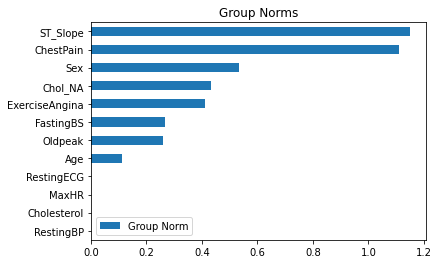

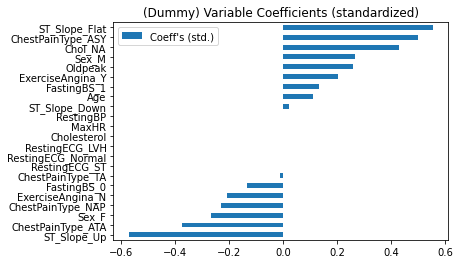

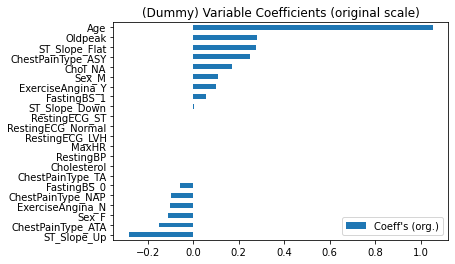

In [134]:
# get estimated coefficients
coeffs_std = lgl.coef_[:, 1] - lgl.coef_[:, 0]

# scale back to original scales
coeffs_org = np.reshape(coeffs_std, (1,len(coeffs_std)))
coeffs_org = scaler.inverse_transform(coeffs_org)
coeffs_org = np.reshape(coeffs_org, coeffs_std.shape)

# group norms
group_norms = np.array([[np.nan]]*n_groups)
for i in range(n_groups):
  group_coeffs = coeffs_std[groups==i]
  group_norms[i,:] = np.linalg.norm(group_coeffs, ord=1)
group_norms = np.reshape(group_norms, (12,))

# make pretty & plot
group_norms = pd.DataFrame({"Group Norm": group_norms},
                           index=group_names)
coeffs_std = pd.DataFrame({"Coeff's (std.)": coeffs_std},
                          index = ft_names)
coeffs_org = pd.DataFrame({"Coeff's (org.)": coeffs_org},
                          index = ft_names)
group_norms = group_norms.sort_values(by="Group Norm")
coeffs_std = coeffs_std.sort_values(by="Coeff's (std.)")
coeffs_org = coeffs_org.sort_values(by="Coeff's (org.)")

group_norms.plot.barh()
plt.title("Group Norms")
coeffs_std.plot.barh()
plt.title("(Dummy) Variable Coefficients (standardized)")
coeffs_org.plot.barh()
plt.title("(Dummy) Variable Coefficients (original scale)")

Group norms (of standardized coefficients) indicate importances of groups of features. In this case, *ST_Slope* and *ChestPain* offered the most predictive value for *HeartDisease*. After cross-validation, group lasso de-selected *RestingBP*, *Cholesterol*, *MaxHR*, and *RestingECG*.

The standardized coefficient estimates allow us to compare importances of variables. For example, asymmetric chest pain shows high positive association with heart disease, while it is negatively associated with an upward ST slope. Interestingly, also whether the cholesterol value was originally 0 had high predictive power.

The original coefficient estimates allow us to infer the association between risk of heart disease and the features. For example, we would expect the log-odds of *HeartDisease* to increase by $\approx 1.0$ for every additional year of age. Note that coefficients of dummy variables need to be interpreted *relative* to the other dummies. For example, *ST_Slope = "Flat"* increases the log-odds of *HeartDisease* by $\approx 0.3$, while *ST_Slope = "Up"* *decreases* it by $\approx 0.3$, and hence the log-odds of a patient with *ST_Slope = "Flat"* are about 0.6 higher than those of a patient with *ST_Slope = "Up"*.

We note that Lasso only selects variables relevant for prediction, and there is no guarantee of it identifying the *causal* variables. In our case, for example, although the estimate for *ST_Slope = "Up"* is significant, we saw above that it is significantly correlated with *ExerciseAngina*, and hence the latter might explain *HeartDisease* nearly as well.

Model performance

In [135]:
## get predicted probabilities and labels of HeartDisease

y_pred_prob = lgl.predict_proba(X_test)[:,1]
y_pred = lgl.predict(X_test)

              precision    recall  f1-score   support

        HD=0       0.85      0.74      0.79        74
        HD=1       0.84      0.91      0.87       110

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



Text(0, 0.5, 'True Positive Rate')

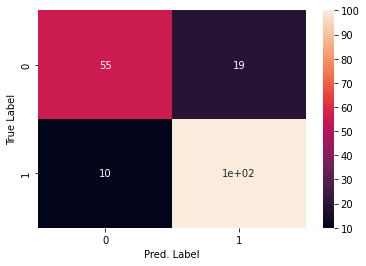

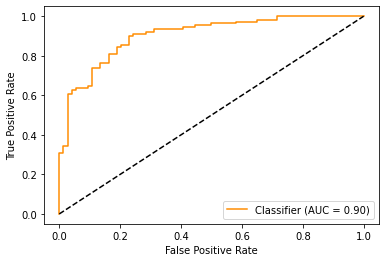

In [136]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

# precision, recall, f1, ...
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

# confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Pred. Label")
plt.ylabel("True Label")

# ROC curve
RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_prob,
    color = "darkorange",)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Our logistic regression classifier for heart disease prediction with group lasso regularization achieved an overall accuracy of 83%. Precision is 83% and recall/sensitivity is 90%, yielding an F1-score of 86%, while specificity is 73%. The AUC of the classifier is 0.90, which is well above the uninformed level of 0.50.

## **Q3: Decision Tree**

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(criterion="gini",
                                random_state=1)

grid = {"max_depth": np.arange(1,8),
        "min_samples_leaf": 2**np.arange(0,7)
        }

cv = GridSearchCV(estimator=tree, param_grid=grid, scoring="f1", cv=5)
cv.fit(X_train, y_train)

opt_tree = cv.best_estimator_

Text(0.5, 1.0, 'Feature Importance Scores (Gini): Decision Tree')

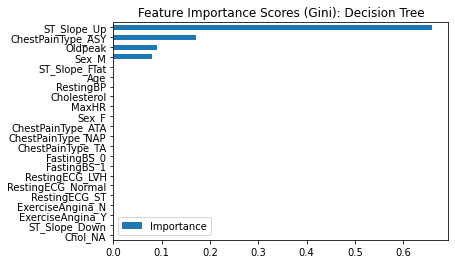

In [74]:
## feature importances

ft_importances = pd.DataFrame({"Importance": opt_tree.feature_importances_},
                              index = ft_names)

ft_importances = ft_importances.sort_values(by="Importance")
ft_importances = ft_importances.round(2)
ft_importances.plot.barh()
plt.title("Feature Importance Scores (Gini): Decision Tree")

[Text(0.5, 0.875, 'ST_Slope_Up <= 1.008\n734\n[336, 398]\nHD=1'),
 Text(0.25, 0.625, 'Sex_M <= 1.208\n412\n[74, 338]\nHD=1'),
 Text(0.125, 0.375, 'ChestPainType_ASY <= 1.001\n68\n[34, 34]\nHD=0'),
 Text(0.0625, 0.125, '29\n[23, 6]\nHD=0'),
 Text(0.1875, 0.125, '39\n[11, 28]\nHD=1'),
 Text(0.375, 0.375, 'ChestPainType_ASY <= 1.001\n344\n[40, 304]\nHD=1'),
 Text(0.3125, 0.125, '101\n[26, 75]\nHD=1'),
 Text(0.4375, 0.125, '243\n[14, 229]\nHD=1'),
 Text(0.75, 0.625, 'ChestPainType_ASY <= 1.001\n322\n[262, 60]\nHD=0'),
 Text(0.625, 0.375, 'Oldpeak <= 1.711\n223\n[210, 13]\nHD=0'),
 Text(0.5625, 0.125, '215\n[207, 8]\nHD=0'),
 Text(0.6875, 0.125, '8\n[3, 5]\nHD=1'),
 Text(0.875, 0.375, 'Oldpeak <= 0.416\n99\n[52, 47]\nHD=0'),
 Text(0.8125, 0.125, '66\n[47, 19]\nHD=0'),
 Text(0.9375, 0.125, '33\n[5, 28]\nHD=1')]

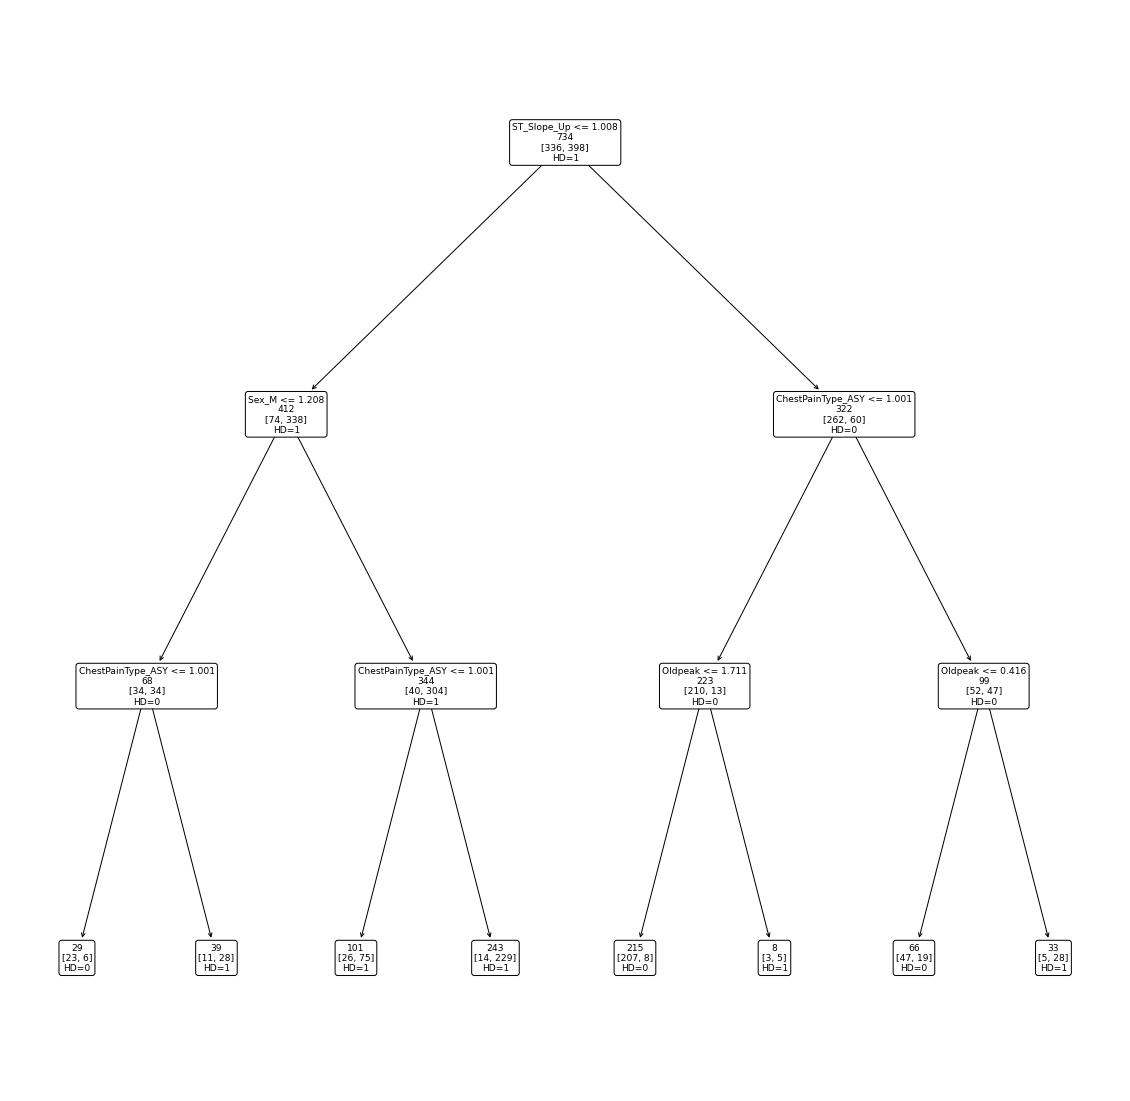

In [75]:
## inspect tree structure
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 20))
plot_tree(opt_tree, feature_names=ft_names, class_names=["HD=0", "HD=1"],
          label="none", impurity=False,
          rounded=True)

Similar to the case of Lasso, the automatic feature selection of decision trees becomes arbitrary if two or more features are highly correlated.

Model performance

In [76]:
y_pred_prob = opt_tree.predict_proba(X_test)[:,1]
y_pred = opt_tree.predict(X_test)

              precision    recall  f1-score   support

        HD=0       0.79      0.65      0.71        74
        HD=1       0.79      0.88      0.83       110

    accuracy                           0.79       184
   macro avg       0.79      0.77      0.77       184
weighted avg       0.79      0.79      0.78       184



Text(0, 0.5, 'True Positive Rate')

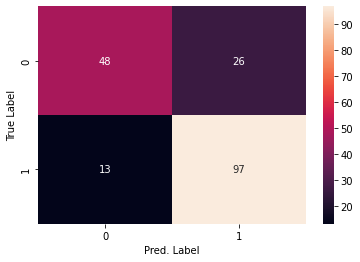

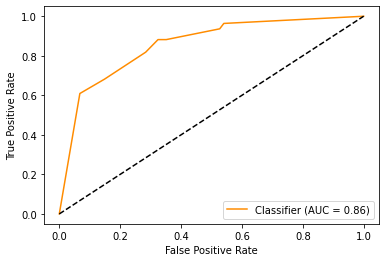

In [77]:
# precision, recall, f1, ...
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

# confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Pred. Label")
plt.ylabel("True Label")

# ROC curve
RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_prob,
    color = "darkorange",)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Overall, the decision tree only performs slightly worse than group lasso, despite it arguably being significantly more restricted (piecewise constant decision boundaries vs linear; 7 features used vs 16).

## **Challenge 1: Neural Additive Models**

https://pypi.org/project/nam/

In [202]:
!pip install nam
from nam.config import defaults
from nam.data import FoldedDataset, NAMDataset
from nam.models import NAM, get_num_units
from nam.trainer import LitNAM
from nam.utils import *

In [197]:
config = defaults()

In [198]:
import sklearn
housing = sklearn.datasets.fetch_california_housing()

dataset = pd.DataFrame(data=housing.data, columns=housing.feature_names)
dataset['target'] = housing.target

config.regression = True

dataset = NAMDataset(config,
                      data_path=dataset,
                      features_columns=dataset.columns[:-1],
                      targets_column=dataset.columns[-1])


## Getting the training dataloaders
dataloaders = dataset.train_dataloaders()

In [199]:
model = NAM(
  config=config,
  name="NAM_GALLUP",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)

In [201]:
for fold, (trainloader, valloader) in enumerate(dataloaders):

    tb_logger = TensorBoardLogger(save_dir=config.logdir,
                                name=f'{model.name}',
                                version=f'fold_{fold + 1}')

    checkpoint_callback = ModelCheckpoint(filename=tb_logger.log_dir +
                                        "/{epoch:02d}-{val_loss:.4f}",
                                        monitor='val_loss',
                                        save_top_k=config.save_top_k,
                                        mode='min')

    litmodel = LitNAM(config, model)
    trainer = pl.Trainer(logger=tb_logger,
                       max_epochs=config.num_epochs,
                       checkpoint_callback=checkpoint_callback)
    trainer.fit(litmodel,
              train_dataloader=trainloader,
              val_dataloaders=valloader)


## Testing the trained model
trainer.test(test_dataloaders=dataset.test_dataloaders())

NameError: ignored

Mar's Code

In [143]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 20 11:35:06 2023

@author: marvazquezrabunal
"""

import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy

#------------------------------------------------------------------------------

### Load the data set

X = X_train
y = y_train


#------------------------------------------------------------------------------

### Create a Dataset object for the data

class CaliforniaDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, scale_data=True):
      if not torch.is_tensor(X) and not torch.is_tensor(y):
        if scale_data:
            X = StandardScaler().fit_transform(X)
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
  
dataset = CaliforniaDataset(X.to_numpy(), y.to_numpy())


#------------------------------------------------------------------------------

### Create small neural network for each one of the features

class INTER(nn.Module):
  def __init__(self):
    super(INTER, self).__init__()
    self.fc1 = nn.Linear(1, 100)
    self.fc2 = nn.Linear(100, 50)
    self.fc3 = nn.Linear(50, 1)
    #self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = x.to(torch.float32)
    out = F.relu(self.fc1(x))
    #out = self.dropout(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out


### Create the NAM 

class NAM_reg(nn.Module):
  def __init__(self):
    super(NAM_reg, self).__init__()
    self.interm = torch.nn.ModuleList([
        INTER()
        for i in range(8)
    ])
    self.fc4 = nn.Linear(8, 1)

  def forward(self, x):
    x = x.to(torch.float32)
    residual = x
    f_out = torch.cat(self._feature_nns(x), dim=-1)
    res2 = self.fc4(residual)
    output = f_out.sum(axis=-1)+res2.reshape(x.shape[0])
    return output, f_out

  def _feature_nns(self, x):
    return [self.interm[i](x[:, i].reshape(x.shape[0],1)) for i in range(8)]
  

nam1_reg = NAM_reg()

#------------------------------------------------------------------------------

### Choose optimizer

optimizer = optim.AdamW(nam1_reg.parameters(), lr = 0.01)

#------------------------------------------------------------------------------

### Set batch size and obtain data loader 

batch_size = 500
train_data_loader = torch.utils.data.DataLoader(dataset,
                                                batch_size = batch_size,
                                                shuffle = True)

#------------------------------------------------------------------------------

### Define training loop

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs = 20):
  for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_loader:
      optimizer.zero_grad()
      inputs, target = batch
      output, interm = model(inputs)
      #print(output.shape)
      target = target.to(torch.float32)
      #print(target.shape)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()
      training_loss += loss.data.item()
    training_loss /= len(train_loader)

    model.eval()
    for batch in val_loader:
      inputs, target = batch
      target = target.to(torch.float32)
      #target.reshape((target.shape[0], 1))
      output, interm = model(inputs)
      val_loss = loss_fn(output, target)
      valid_loss += val_loss.data.item()
    valid_loss /= len(val_loader)
    print("Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}".format(epoch, training_loss, valid_loss))

#------------------------------------------------------------------------------

### Fit the model to the data (we are not including any real validation set)

train(nam1_reg, optimizer, nn.MSELoss(), train_data_loader, train_data_loader, 20)

#------------------------------------------------------------------------------

### Prediction of the model and quality of fit (coef of determination)

pred = nam1_reg(dataset.X)[0].detach().numpy()
real_y = dataset.y.numpy()

SS_res = ((pred.reshape(20640,1)-real_y.reshape(20640,1))**2).sum()/(pred.shape[0])
SS_tot = ((real_y-real_y.mean())**2).mean()

1-SS_res/SS_tot

#------------------------------------------------------------------------------

### Plot non linear behaviour features

### For each batch obtain the individual feature prediction and the features
out = torch.empty(0,8)
x_shuff = torch.empty(0,8)
for batch in train_data_loader:
  x1, y1 = batch
  interm_res = nam1_reg(x1)[1]
  #print(interm_res.shape)
  x_shuff = torch.cat((x_shuff, x1), 0)
  out = torch.cat((out, interm_res), 0)


### Plot
plt.rcParams["figure.figsize"] = (18,9) 
colors = cm.rainbow(numpy.linspace(0, 1, 8))
for i in range(8):
  axis_x = x_shuff[:, i]
  axis_y = out[:, i]
  plt.subplot(2,4,i+1)
  plt.scatter(axis_x.detach().numpy(), axis_y.detach().numpy(), color = colors[i])
  plt.title("Feature "+str(i+1))
fig1 = plt.gcf()

### Save plot
fig1.savefig("Nam3")

#------------------------------------------------------------------------------

### Using skorch (we will have to install it first)
from skorch import NeuralNet

### We create the NAM (a bit different from before because we just want one output)
class NAM_reg2(nn.Module):
  def __init__(self):
    super(NAM_reg2, self).__init__()
    self.interm = torch.nn.ModuleList([
        INTER()
        for i in range(8)
    ])
    self.fc4 = nn.Linear(8, 1)

  def forward(self, x):
    x = x.to(torch.float32)
    residual = x
    f_out = torch.cat(self._feature_nns(x), dim=-1)
    res2 = self.fc4(residual)
    output = f_out.sum(axis=-1)+res2.reshape(x.shape[0])
    output = output.reshape(output.shape[0],1)
    return output

  def _feature_nns(self, x):
    return [self.interm[i](x[:, i].reshape(x.shape[0],1)) for i in range(8)]


### We fit the NAM
net = NeuralNet(
    NAM_reg2,
    max_epochs= 20,
    criterion=torch.nn.MSELoss,
    lr = 0.01,
    train_split = None,
    optimizer = torch.optim.AdamW,
    iterator_train__shuffle=True)

X2 = dataset.X.numpy().astype(numpy.float32)
y2 = dataset.y.numpy().astype(numpy.float32)
y2 = y2.reshape(-1, 1)

net.fit(X2, y2)

### Prediction and quality of fit
y_pred = net.predict(X2)
y_pred2 = y_pred.reshape(20640,1)
real_y = y2
real_y2 = real_y.reshape(20640,1)

SS_res = ((y_pred2-real_y2)**2).sum()/(y_pred2.shape[0])
SS_tot = ((real_y2-real_y2.mean())**2).mean()

1-SS_res/SS_tot

RuntimeError: ignored